In [1]:
# Python Free Fermion Large Scale Simulation Platform (FermiNet) Tutorials
# Author: Bill Zhai pzhai@g.harvard.edu
# PI: Susanne F. Yelin
# Nov 30, 2022

In [2]:
# My PyFerm modules:
from Utils_torch_version import Network, get_nn_pairs, binary_basis, unpacknbits, initialize_sparse

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import scipy
import scipy.linalg
import time
import torch # PyTorch is required for this demo
import qiskit # Qiskit is required for this demo
import math

# Example 3: Multi-layer Circuit

The power of FermiNet really comes down to the fact that it can efficiently model a series of quantum gates, each corresponds to a continuous Hamiltonian time evolution, forming a multi-layer parameterized circuit. The network takes an input state denoted by a bitstring, and <b>computes the probability density value of observing any bitstring y in polynomial time of the number of qubits. </b>

More formally, a FermiNet object is a parameterized computing model $f_{\theta}(y;x)$, which takes in two bitstrings $y$ and $x$ and outputs the probability density $p(y|x)$. This model is multi-purpose, and can be used as a general quantum ansatz, a quantum generative/classification model, a classical quantum simulation platform for quantum systems, etc.

Here we demonstrate how to build a multi-layer parametrized quantum circuit with FermiNet classes and functions.

We define one circuit gate as $H_g$, and each gate corresponds to a continuous evolution $e^{-i\mathcal{H}t}$. A parametrized is a series of such evolutions:

$U_{total} = U_L U_{L-1}...U_{2} U_1, $

where $U_l$ is the $l$-th "layer" defined as:

$U_l = e^{-i\mathcal{H}_{l}t},$

where $\mathcal{H}_{l}$ concerns interactionos of two Fermionic modes $i<j$, not necessarily nearest-neighbor. In this example, we use a simple construction:

$\begin{equation}
    \begin{aligned}
        \mathcal{H}_{l} &=b_{i i} a_i^{\dagger} a_i+b_{j j} a_j^{\dagger} a_j+(c+di) a_i^{\dagger} a_j+(c-di) a_j^{\dagger} a_i \\ &= -\frac{1}{2} \left(b_{ii} Z_i + b_{jj} Z_j\right)+\frac{c}{2} \left(Y_i \left(\prod_{k=i+1}^{j-1} Z_k\right) Y_j + X_i \left(\prod_{k=i+1}^{j-1} Z_k\right) X_j \right)\\
        &+\frac{d}{2}\left(Y_i \left(\prod_{k=i+1}^{j-1} Z_k\right) X_j - X_i \left(\prod_{k=i+1}^{j-1} Z_k\right) Y_j \right),
    \end{aligned}
\end{equation}$

In [3]:
# Define the model configurations
N = 10
# Connectivity (i,j) of each "layer" where i<j.
conn_list = [ [np.min(p), np.max(p)] for p in get_nn_pairs(geometry=(N,))]*3 # zero indexed and should not be periodic (not a closed circle)
L = len(conn_list)
print('Connectivity list: ', conn_list)
print('Total layers: ', L)

Connectivity list:  [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [1, 2], [3, 4], [5, 6], [7, 8], [0, 9], [0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [1, 2], [3, 4], [5, 6], [7, 8], [0, 9], [0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [1, 2], [3, 4], [5, 6], [7, 8], [0, 9]]
Total layers:  30


In [4]:
# Define the circuit, calling the FermiNet "Network" class
circuit = Network(conn_list, N)

# Define an input state, in this case, a simple 1010...1010 basis state
# Note: x should follow the shape (batch_size, 2^N), even for a batch_size=1
x = torch.tensor([[1,0]*int(N/2)]) if N%2==0 else torch.tensor([[1,0]*int(N/2)+[1]])

# When the circuit is initialized, the parameters are randomly initiailized by pi * Uniform([0,1]):
# for param in circuit.parameters():
#     print('Network parameters', param)

# Hereby we take an extra step to show you how to manually set these parameters:
params_m = torch.tensor(math.pi) * torch.rand((L, 4)) # Each layer has 4 rotations
print('params_m',params_m)

circuit.manual_set_params(params_m)

params_m tensor([[2.1910, 1.7846, 1.7241, 0.4761],
        [3.0786, 2.7891, 1.8255, 0.4091],
        [1.8787, 2.4286, 1.9774, 2.1277],
        [1.5737, 2.4302, 1.3105, 2.5538],
        [0.2247, 1.5417, 1.8586, 0.0715],
        [1.8883, 0.1934, 0.6493, 1.6857],
        [2.2582, 2.9124, 0.5533, 1.9847],
        [0.8672, 2.8429, 0.6088, 0.9042],
        [2.8714, 0.6085, 0.3729, 1.6372],
        [0.7470, 0.0629, 1.0170, 1.9813],
        [0.4138, 2.9804, 0.1038, 1.8424],
        [1.3245, 0.8730, 0.1453, 1.4728],
        [1.1769, 0.4001, 1.3690, 0.6002],
        [1.3366, 3.1192, 1.3299, 2.8912],
        [0.9787, 1.7115, 2.8601, 2.2649],
        [2.4606, 0.1110, 1.5370, 0.6468],
        [3.0445, 2.6927, 0.1269, 2.2172],
        [1.9287, 1.7762, 1.1296, 2.8213],
        [0.4035, 1.5391, 1.9781, 0.7876],
        [0.2310, 1.9855, 1.0516, 2.6008],
        [2.3990, 0.1983, 0.7619, 0.6665],
        [1.2696, 1.2882, 3.1212, 0.8932],
        [0.6960, 1.7674, 1.0291, 2.6033],
        [1.3618, 0.5153, 

In [5]:
# Compute the probabilities of observing all possible bitstrings
# FermiNet supports batch processing too!

probs = torch.zeros(2**N, dtype=torch.cfloat) # To collect the probability densitives evaluations
basis_m_n = torch.tensor(binary_basis(geometry=(N,)))

# This demonstrates how to process P(y|x) by batches: P(y_batch|x_batch) results in a batch of probabilities
batch_size = 16
n_batches = len(probs)//batch_size if len(probs)%batch_size == 0 else len(probs)//batch_size+1

ts = time.time()
for i in range(n_batches):
    y_batch = basis_m_n[batch_size*i : batch_size*(i+1)] # shape is (batch_size, 2^N)
    x_batch = x.repeat(y_batch.shape[0], 1) # shape is (batch_size, 2^N)
    
    # In this example, we measure all the qubits at the end, so the mask is 1111..111
    sub_mask_batch = (torch.tensor([ [1]*N ])).repeat(y_batch.shape[0], 1) # shape is (batch_size, 2^N)
    # call circuit.forward_partial_observation() to get the P(y|x) values
    probs_batch = circuit.forward_partial_observation(y_batch, x_batch, sub_mask_batch)
    # Now put these probs_batch values into correct positions
    probs[batch_size*i : batch_size*(i+1)] = probs_batch
print('probs', probs)
# The returned probs are torch tensors, so detach the gradients and convert to numpy:
probs = probs.detach().numpy().real

tf = time.time()
print('time lapsed: ', str(tf-ts))

probs tensor([0.+0.j, 0.-0.j, 0.-0.j,  ..., 0.+0.j, 0.-0.j, 0.-0.j],
       grad_fn=<CopySlices>)
time lapsed:  1.6140539646148682


Text(0.5, 1.0, 'Fermion Simulation time lapsed 1.6140539646148682')

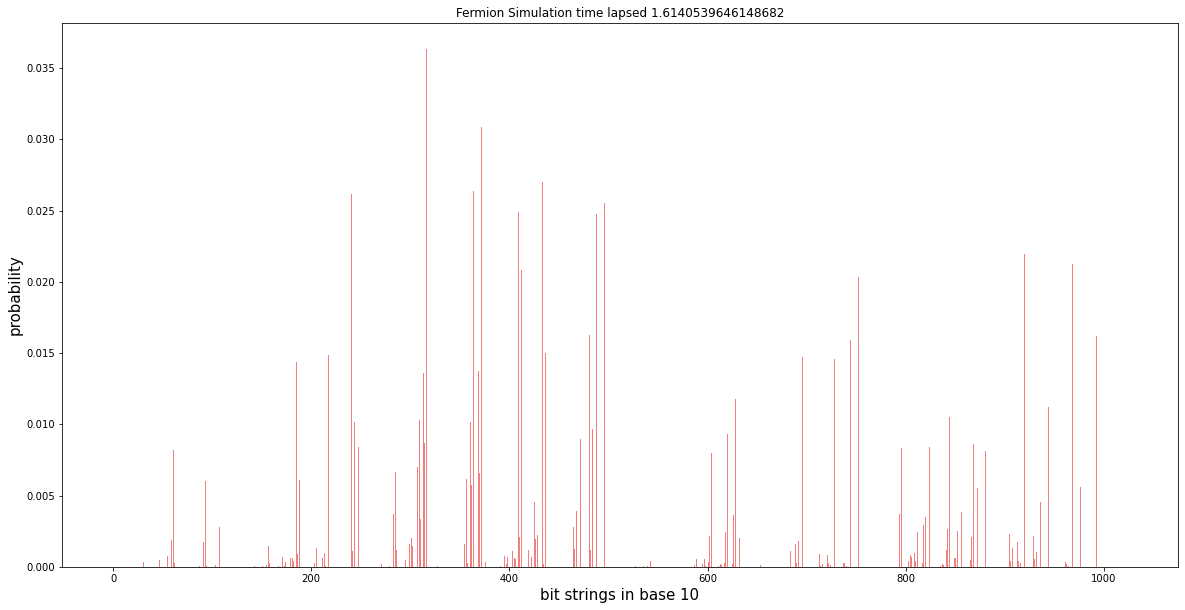

In [6]:
fig, ax = plt.subplots(figsize=(20, 10))
xs = np.arange(2**N)
ax.bar(xs, probs, color='lightcoral')
ax.set_xlabel('bit strings in base 10', fontsize=15)
ax.set_ylabel('probability', fontsize=15)
ax.set_title('Fermion Simulation time lapsed '+str(tf-ts ))

# Compare with Exact Diagonalization 

Should we trust the Fermion simulations? Now let's compare the simulation results with exact diagonalization (ED). Notice how much faster the Fermion simulation runs!

In [7]:
x_string = '10'*int(N/2)+'1' if N%2==1 else '10'*int(N/2)
init_state_numpy = qiskit.quantum_info.Statevector.from_label(x_string).data

ts = time.time()
# Initialize the evolution matrix
exp_iH_exact = np.eye(2**N)
# Iterate each layer and get the composition via matrix multiplication
# Use the same params_m rotations defined earliers
for l in range(L):
    conn = conn_list[l]
    a, b, c, d = params_m.detach().numpy()[l]
    H_exact = initialize_sparse(N, conn[0], conn[1], a, b, c, d)
    exp_iH_exact = (scipy.linalg.expm(-1.0j*H_exact))@exp_iH_exact 

state_exact = np.matmul(exp_iH_exact, init_state_numpy[:,None])
probs_exact = (np.abs(state_exact)**2).squeeze()

tf = time.time()

Text(0.5, 1.0, 'Exact Diagonalization time lapsed 26.530390739440918')

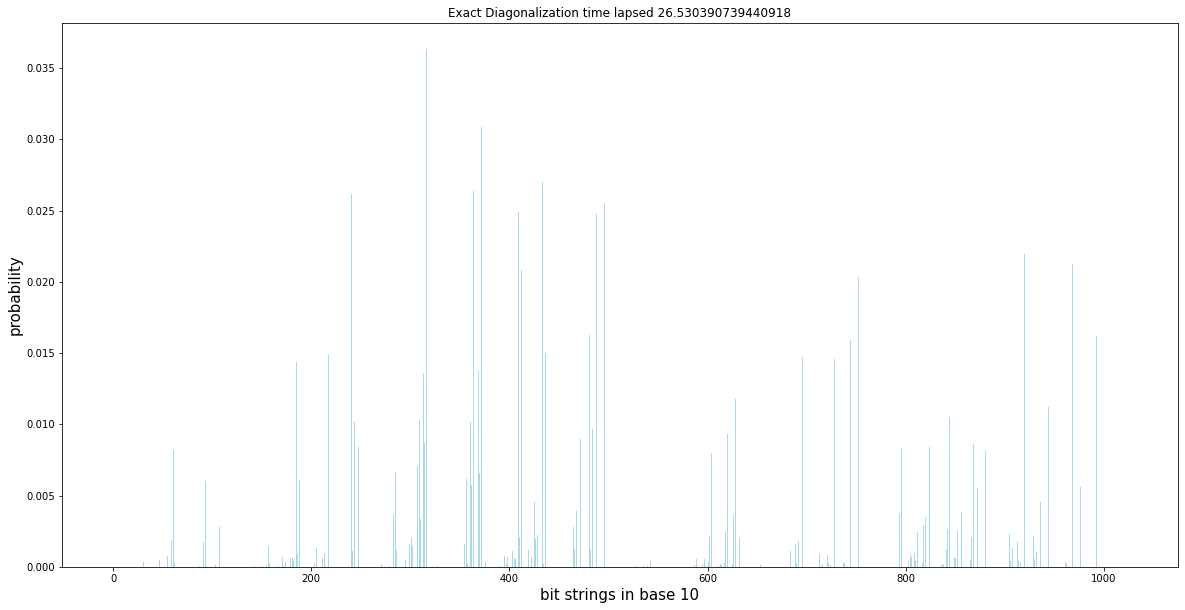

In [8]:
fig, ax = plt.subplots(figsize=(20, 10))
xs = np.arange(2**N)
ax.bar(xs, probs_exact, color='lightblue')
ax.set_xlabel('bit strings in base 10', fontsize=15)
ax.set_ylabel('probability', fontsize=15)
ax.set_title('Exact Diagonalization time lapsed '+str(tf-ts ))

Text(0.5, 1.0, 'Total variation: 4.595087798274692e-12')

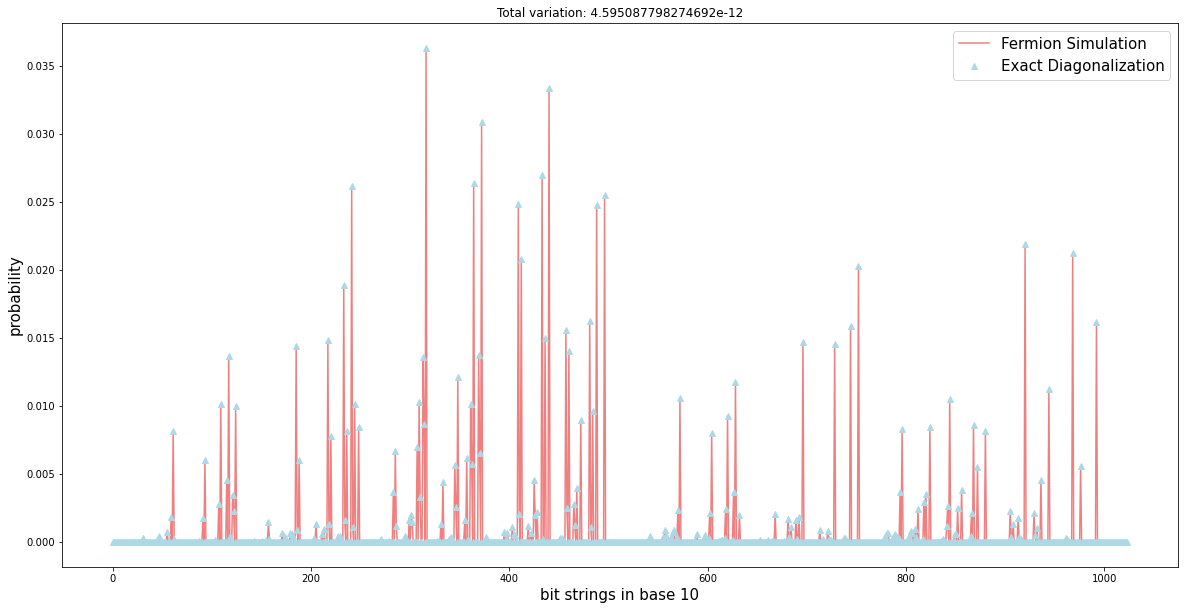

In [9]:
# Plot two against each other
fig, ax = plt.subplots(figsize=(20, 10))
xs = np.arange(2**N)
ax.plot(xs, probs, color='lightcoral')
ax.plot(xs, probs_exact, '^', color='lightblue')

ax.set_xlabel('bit strings in base 10', fontsize=15)
ax.set_ylabel('probability', fontsize=15)

ax.legend(['Fermion Simulation', 'Exact Diagonalization'], fontsize=15)
tv = (np.abs(probs-probs_exact)**2).sum()
ax.set_title('Total variation: '+str(tv))